In [3]:
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.preprocessing import normalize
from alive_progress import alive_bar
import os
import glob
from scipy.ndimage import median_filter
from tqdm import tqdm
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

Processed data shape from C:\Users\batua\Downloads\3rdGen_2024_newcystSamples_samePatients-20240710T165245Z-001\3rdGen_2024_newcystSamples_samePatients\20240709_Diluton_sample123\Dilution_123_10mW\1e12\s_1: (1650, 2)
Processed data shape from C:\Users\batua\Downloads\3rdGen_2024_newcystSamples_samePatients-20240710T165245Z-001\3rdGen_2024_newcystSamples_samePatients\20240709_Diluton_sample123\Dilution_123_10mW\1e12\s_10: (1650, 2)
Processed data shape from C:\Users\batua\Downloads\3rdGen_2024_newcystSamples_samePatients-20240710T165245Z-001\3rdGen_2024_newcystSamples_samePatients\20240709_Diluton_sample123\Dilution_123_10mW\1e12\s_100: (1650, 2)
Processed data shape from C:\Users\batua\Downloads\3rdGen_2024_newcystSamples_samePatients-20240710T165245Z-001\3rdGen_2024_newcystSamples_samePatients\20240709_Diluton_sample123\Dilution_123_10mW\1e12\s_101: (1650, 2)
Processed data shape from C:\Users\batua\Downloads\3rdGen_2024_newcystSamples_samePatients-20240710T165245Z-001\3rdGen_2024_new

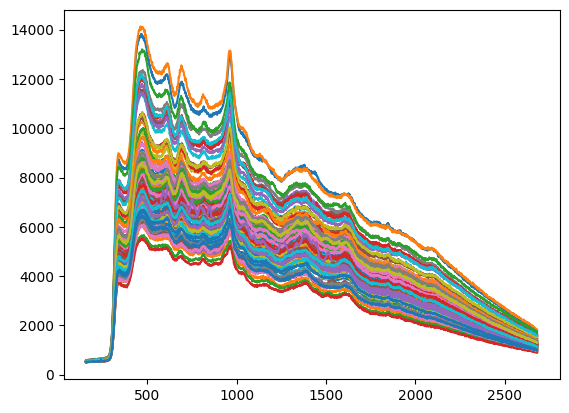

In [4]:

#Calibrate the x-axis of Raman Spectral Data(Create a polynomial that, when applied to pixel values, will change them to Raman Shift values)

#Provide pixel values of identifiable peaks from a Raman Spectrum that was taken with your machine
dataset1 = [116,
184.5,
251,
376,
480,
785,
974
]

#Provide Raman Shift Values of the same peaks that are of the same sample, taken from literature
dataset2 = [365.676,
484.588,
601,
812.223,
974.5,
1451.85,
1728.9
 ]

# Fit polynomial model
mymodel = np.poly1d(np.polyfit(dataset1, dataset2, 3))


# Directory containing Raman Spectrum Files
directory = 
# List to hold the processed numpy arrays
all_data = []
fitted_x = None

# Process each CSV file in the directory
for filepath in glob.glob(os.path.join(directory, '*')):
    # Check if it's a file and not a directory
    if os.path.isfile(filepath):
        # Read the file into a pandas DataFrame
        df = pd.read_csv(filepath, header=None)
        
        # Convert the DataFrame to a numpy array
        data = df.values
        
        # Apply the polynomial model to the first file's x-axis
        if fitted_x is None:
            x = data[:, 0]
            fitted_x = mymodel(x)
        
        # Replace the first column with the fitted x values
        data[:, 0] = fitted_x
        
        # Append the processed data to the list
        all_data.append(data[:, 1:])  # Exclude the first column (x-axis) for merging

        # Debugging: Print shape of each array
        print(f'Processed data shape from {filepath}: {data.shape}')

# Ensure there is at least one array to concatenate
if len(all_data) > 0:
    # Stack columns (all files should have the same number of rows)
    merged_data = np.column_stack(all_data)
    
    # Example: Print the shape of the merged data array
    print(f'Merged data shape: {merged_data.shape}')
    

else:
    print("No data was processed. Please check the input directory and files.")
plt.plot(fitted_x, merged_data)

In [6]:
#Assign the fitted values to a dataframe
preproc_df = pd.DataFrame(data=merged_data, index=fitted_x, columns=np.arange(merged_data.shape[1]))


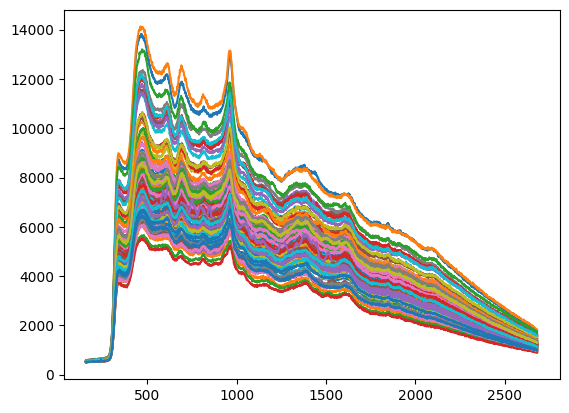

In [9]:
plt.plot(preproc_df)
Plot_Option=True

In [11]:
#Preprocessing Pipeline

#Necessary Functions
def crop_spectrum(spectrum, lb, ub):
    return spectrum[lb:ub+1]

def despike_spectrum(spectrum, threshold=5):
    filtered = median_filter(spectrum, size=3)
    spikes = np.abs(spectrum - filtered) > threshold
    spectrum[spikes] = filtered[spikes]
    return spectrum

def baseline_als(y, lam=1e5, p=0.01, niter=10):
    L = len(y)
    D = np.diff(np.eye(L), 2)
    w = np.ones(L)
    for i in range(niter):
        W = np.diag(w)
        Z = W + lam * D.dot(D.T)
        z = np.linalg.solve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    
    return z

def baseline_correction(spectrum):
    baseline = baseline_als(spectrum)
    return spectrum - baseline

def l2_normalize(spectrum):
    norm = np.linalg.norm(spectrum)
    if norm == 0:
        return spectrum
    return spectrum / norm

#Preprocess Function
def preprocess(data, lb, ub):
    """
    data: the dataframe whose spectra need to be preprocessed
    lb: the lower bound for the pixel numbers which need to be kept
    ub: the upper bound for the pixel numbers which need to be kept

    returns: the preprocessed dataframe
    """
    raman_shifts = data.index[lb:ub+1]  # Raman shifts for the given range
    num_pixels = ub - lb + 1  # number of pixels in the processed dataframe

    spectra_array = np.zeros((len(data.columns), num_pixels))
    length = len(data.columns)

    for j in tqdm(range(length)):
        spectrum = data.iloc[:, j].to_numpy()  # Process entire column as spectrum
        cropped_spectrum = crop_spectrum(spectrum, lb, ub)
        despiked_spectrum = despike_spectrum(cropped_spectrum)
        denoised_spectrum = savgol_filter(despiked_spectrum, window_length=21, polyorder=5)
        baseline_corrected_spectrum = baseline_correction(denoised_spectrum)
        normalized_spectrum = l2_normalize(baseline_corrected_spectrum)
        spectra_array[j, :] = normalized_spectrum

    df = pd.DataFrame(spectra_array.T, index=raman_shifts, columns=data.columns)

    print('Finished preprocess!')

    return df
